In [1]:
!pip install psycopg2-binary
!pip install sqlalchemy
!pip install xgboost
!pip install mlxtend
!pip install imblearn

In [2]:
import pandas as pd
import psycopg2
import sqlalchemy 
import pyodbc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, f1_score
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


from collections import Counter
from mlxtend.plotting import plot_decision_regions

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)



In [3]:
params = {
    "host": "localhost",
    "user": "postgres",
    "port": 5432,
    "password": "Aibu2008" 
}
connection = psycopg2.connect(**params, dbname= "postgres")

In [4]:
df=pd.read_sql('select * from public.customer_churn',connection)

C:\Users\bahar.inan\Anaconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [5]:
connection.close()

In [6]:
df

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15606229,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,15569892,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,15584532,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,15682355,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [7]:
df.drop(columns='customer_id',inplace=True) #customer id anlamlı bir feature olmadığından siliyoruz

In [8]:
df.info() 
"""
hiç null değer yok. Object olan country ve gender için get dummies yapalım
age değişkeni için de Discretization uygulayalım.
"""

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   country           10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            10000 non-null  int64  
 5   balance           10000 non-null  float64
 6   products_number   10000 non-null  int64  
 7   credit_card       10000 non-null  int64  
 8   active_member     10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  churn             10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


'\nhiç null değer yok. Object olan country ve gender için get dummies yapalım\nage değişkeni için de Discretization uygulayalım.\n'

In [9]:
df = pd.get_dummies(df, columns=['country','gender'],  drop_first=True)
df

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,country_Germany,country_Spain,gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,96270.64,0,0,0,1
9996,516,35,10,57369.61,1,1,1,101699.77,0,0,0,1
9997,709,36,7,0.00,1,0,1,42085.58,1,0,0,0
9998,772,42,3,75075.31,2,1,0,92888.52,1,1,0,1


In [10]:
df.describe() #yaş min 18 max 92 olduğunu gördük. 18-32 / 33-44 / 45-60 / 60+ olarak gruplayabiliriz

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,country_Germany,country_Spain,gender_Male
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700,0.250900,0.247700,0.545700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769,0.433553,0.431698,0.497932
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000,0.000000,0.000000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000,0.000000,0.000000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000,0.000000,0.000000,1.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000,1.000000,0.000000,1.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000,1.000000,1.000000,1.000000


In [11]:
def discretizate(age):
    if age <=32:
        return '18-32'
    elif age <=44:
        return '33-44'
    elif age <=60:
        return '45-60'
    else:
        return '60+'

In [12]:
df['age_group'] = df['age'].apply(discretizate)
df

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,country_Germany,country_Spain,gender_Male,age_group
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0,33-44
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0,33-44
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0,33-44
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0,33-44
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0,33-44
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,96270.64,0,0,0,1,33-44
9996,516,35,10,57369.61,1,1,1,101699.77,0,0,0,1,33-44
9997,709,36,7,0.00,1,0,1,42085.58,1,0,0,0,33-44
9998,772,42,3,75075.31,2,1,0,92888.52,1,1,0,1,33-44


In [13]:
age_group_dic = {'60+':3, '45-60':2, '33-44':1, '18-32':0}  

df['age_group'] = df['age_group'].map(age_group_dic)
df

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,country_Germany,country_Spain,gender_Male,age_group
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0,1
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0,1
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0,1
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0,1
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,96270.64,0,0,0,1,1
9996,516,35,10,57369.61,1,1,1,101699.77,0,0,0,1,1
9997,709,36,7,0.00,1,0,1,42085.58,1,0,0,0,1
9998,772,42,3,75075.31,2,1,0,92888.52,1,1,0,1,1


In [14]:
df.drop(columns='age',inplace=True) #age kolonunu da drop edelim.

In [15]:
df.info() #tüm değişknlerin tipi int ya da float oldu
df.isnull().sum() #hiç null değer de yok

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   tenure            10000 non-null  int64  
 2   balance           10000 non-null  float64
 3   products_number   10000 non-null  int64  
 4   credit_card       10000 non-null  int64  
 5   active_member     10000 non-null  int64  
 6   estimated_salary  10000 non-null  float64
 7   churn             10000 non-null  int64  
 8   country_Germany   10000 non-null  uint8  
 9   country_Spain     10000 non-null  uint8  
 10  gender_Male       10000 non-null  uint8  
 11  age_group         10000 non-null  int64  
dtypes: float64(2), int64(7), uint8(3)
memory usage: 732.5 KB


credit_score        0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
country_Germany     0
country_Spain       0
gender_Male         0
age_group           0
dtype: int64

In [16]:
df

,credit_score,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,country_Germany,country_Spain,gender_Male,age_group
0,619,2,0.00,1,1,1,101348.88,1,0,0,0,1
1,608,1,83807.86,1,0,1,112542.58,0,0,1,0,1
2,502,8,159660.80,3,1,0,113931.57,1,0,0,0,1
3,699,1,0.00,2,0,0,93826.63,0,0,0,0,1
4,850,2,125510.82,1,1,1,79084.10,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,5,0.00,2,1,0,96270.64,0,0,0,1,1
9996,516,10,57369.61,1,1,1,101699.77,0,0,0,1,1
9997,709,7,0.00,1,0,1,42085.58,1,0,0,0,1
9998,772,3,75075.31,2,1,0,92888.52,1,1,0,1,1


In [17]:
df.to_csv('churn.csv')

In [18]:
df['churn'].value_counts(normalize=True) #dengesiz bir veri seti

0    0.7963
1    0.2037
Name: churn, dtype: float64

In [19]:
#train ve test ayrımı ile modelleri deneyelim.

X_train, X_test, y_train, y_test = train_test_split(df.loc[:,['credit_score','tenure','balance','products_number',
                                                             'credit_card','active_member','estimated_salary','country_Germany',
                                                             'country_Spain','gender_Male','age_group']
                                                          ], 
                                                    
                                                    df.loc [:, 'churn'],
                                                            test_size=0.2, random_state=42)

In [20]:
y_train

9254    0
1561    0
1670    1
6087    1
6669    1
       ..
5734    0
5191    0
5390    1
860     1
7270    0
Name: churn, Length: 8000, dtype: int64

In [21]:
#grafikte görebilmek için hedef ile featureları tekrar aynı dataframe de birlestirelim

train_df = X_train.copy()
train_df['churn'] = y_train

train_df['churn'] = train_df['churn'].apply(lambda x: (x and 'churn') or 'not churn')
train_df.head()

,credit_score,tenure,balance,products_number,credit_card,active_member,estimated_salary,country_Germany,country_Spain,gender_Male,age_group,churn
9254,686,6,0.00,2,1,1,179093.26,0,0,1,0,not churn
1561,632,4,119624.60,2,1,1,195978.86,1,0,1,1,not churn
1670,559,3,114739.92,1,1,0,85891.02,0,1,1,0,churn
6087,561,9,135637.00,1,1,0,153080.40,0,0,0,0,churn
6669,517,9,142147.32,1,0,0,39488.04,0,0,1,2,churn


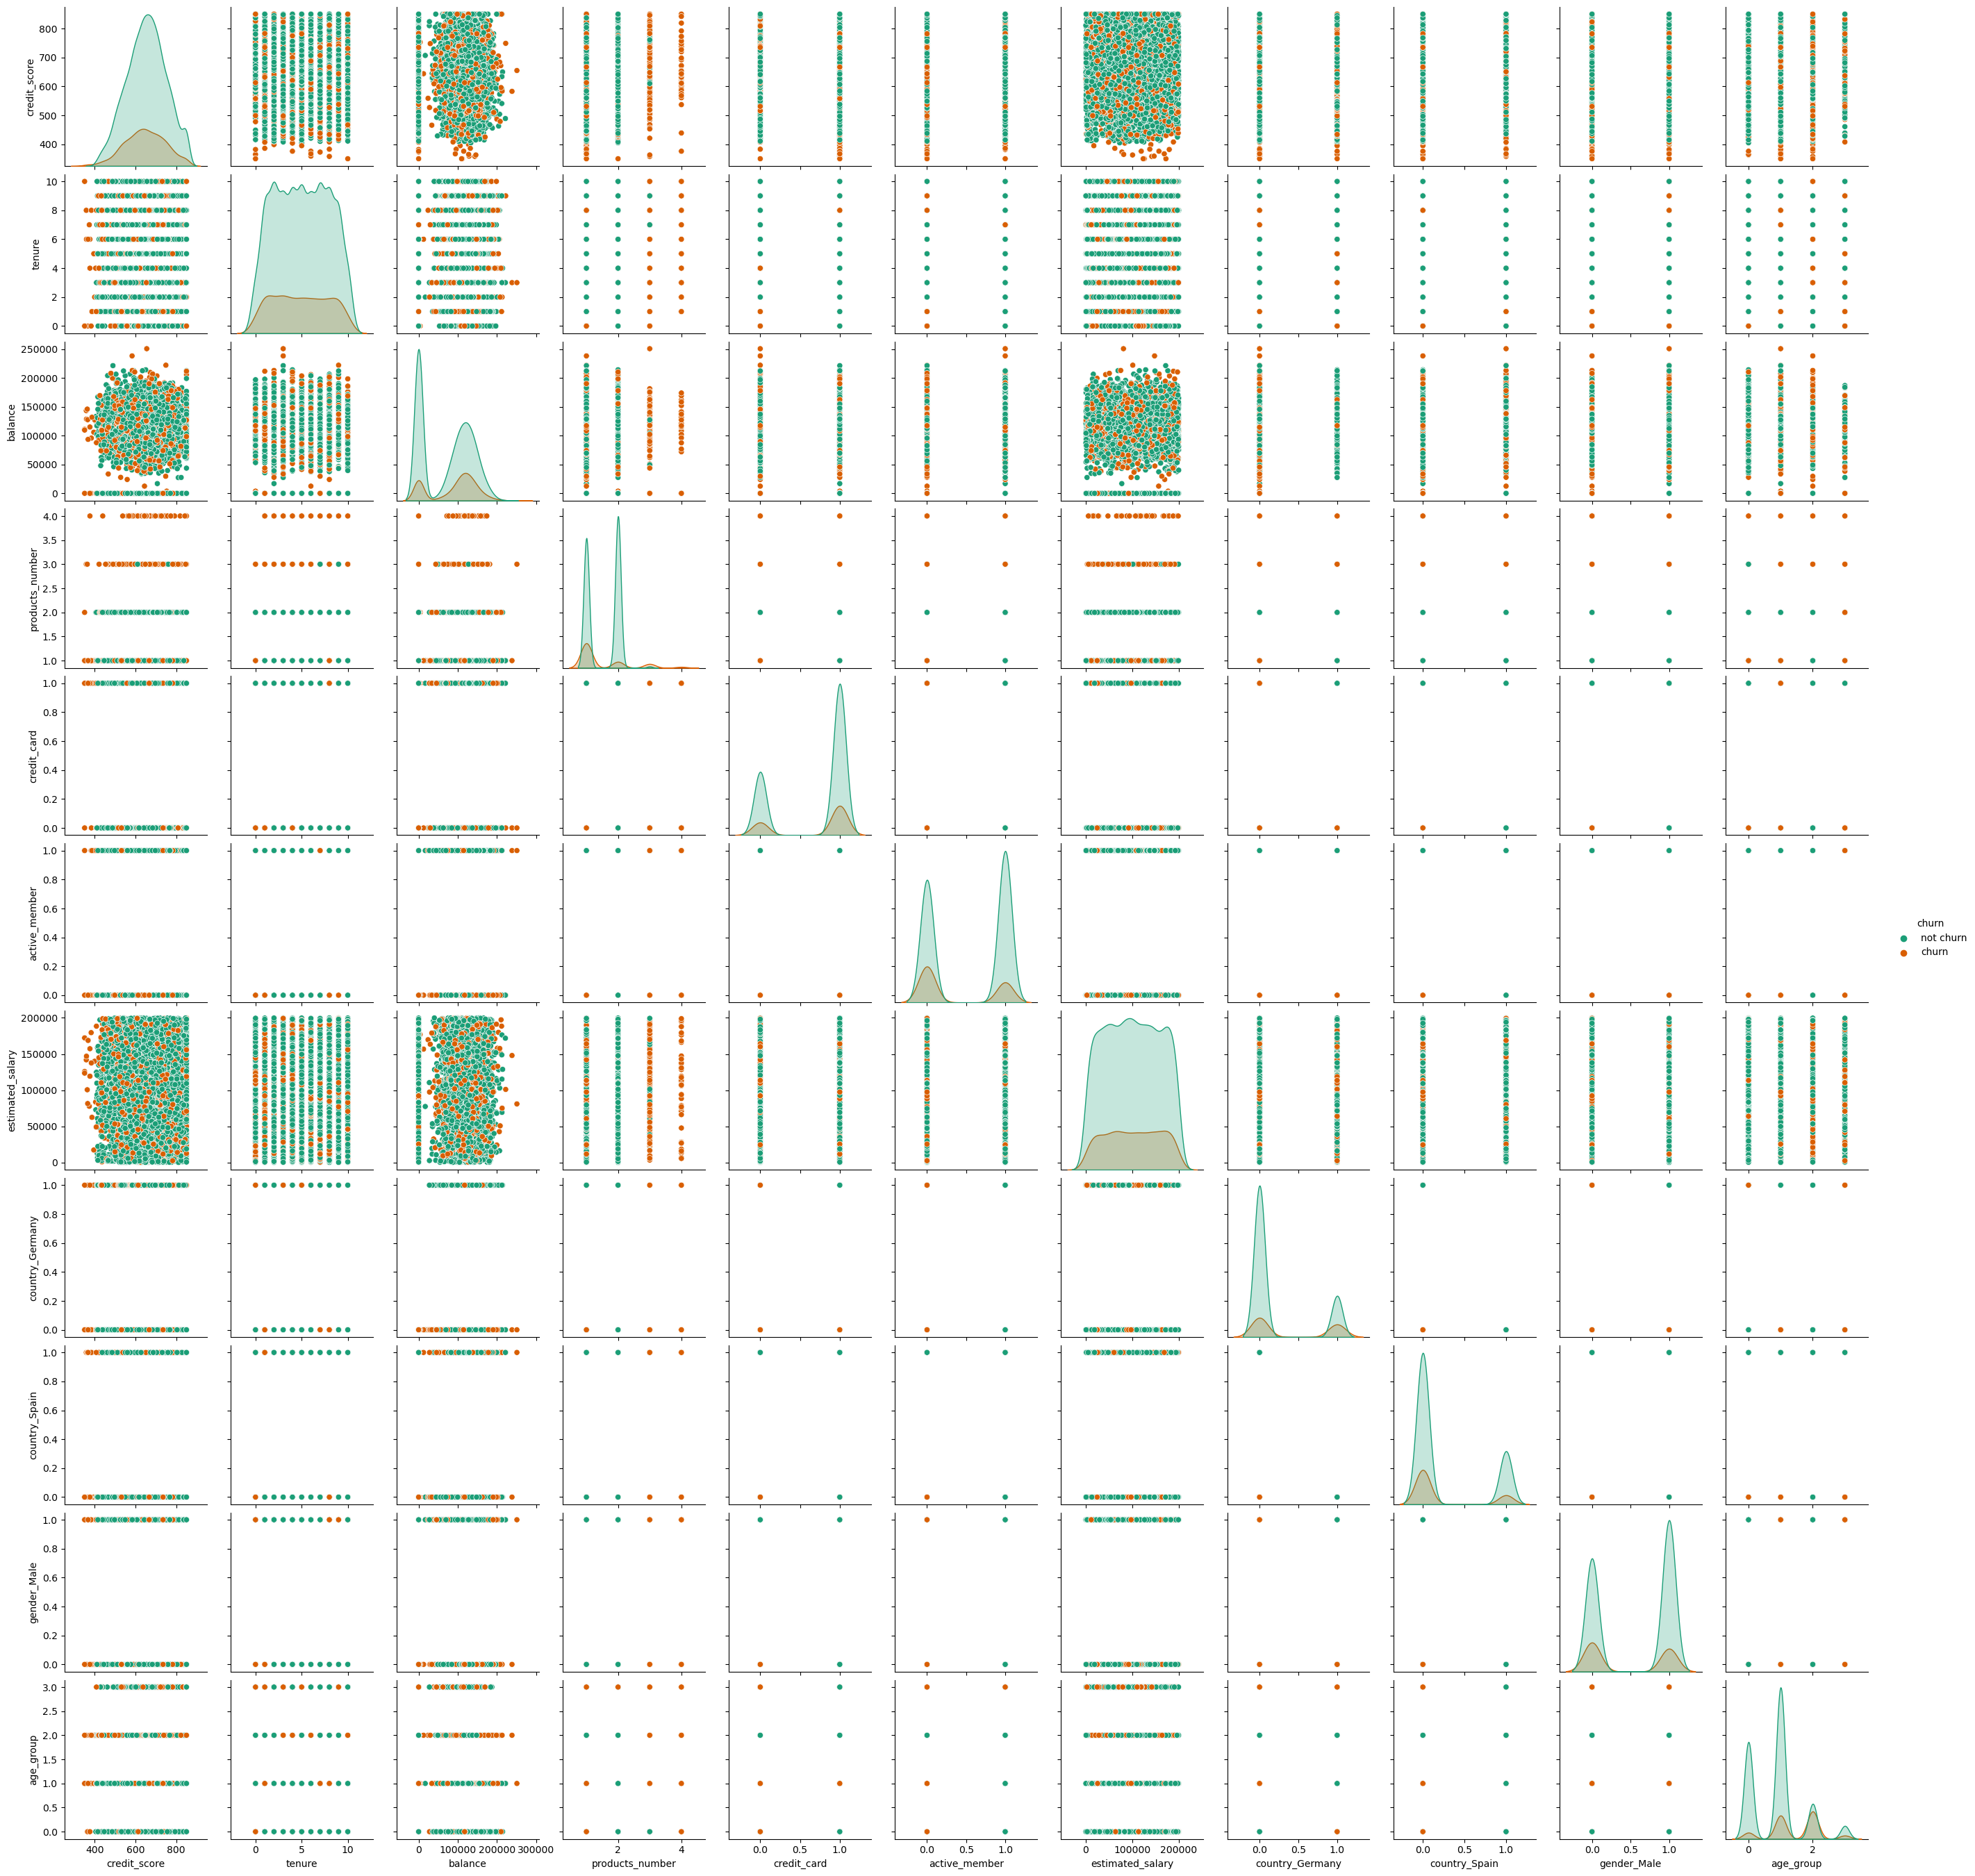

In [22]:
"""
Şimdi de pairplot() fonksiyonundan yararlanarak kişinin churn olmasını etkileyen özellikleri inceleyelim 
ve hangi özellikler daha ön plana çıkmış onları kestirmeye çalışalım.
"""

sns.pairplot(train_df, hue='churn', palette='Dark2');

In [23]:
#değişkenlerin tamamı ayrıştırıcı gibi görünüyor.
#scale işlemini tamamlayarak modelleri deneyelim.


In [27]:
# KNN modelini oluşturma

scale = StandardScaler()

X_train_transformed = scale.fit_transform(X_train)
X_test_transformed = scale.transform(X_test)

knn = KNeighborsClassifier()
knn.fit(X_train_transformed, y_train)

scores = cross_val_score(knn, X_train_transformed, y_train, cv=10, scoring='accuracy') # Veri setini 10 farklı formatta hazırla
print(scores)

[0.82625 0.8225  0.8125  0.835   0.835   0.8225  0.83375 0.815   0.82375
 0.82   ]


In [28]:
print(scores.mean()) #accuracy skorları iyi görünüyor ancak dengesiz veri setlerinde sadece accuracy yeterli olmaz.

0.8246249999999999


In [29]:
print('KNN Training Score: {:6.2f}%'.format(100*knn.score(X_train_transformed, y_train)))
print('KNN Test Score: {:6.2f}%'.format(100*knn.score(X_test_transformed, y_test)))

KNN Training Score:  87.12%
KNN Test Score:  82.65%


In [116]:
#diğer skorlara da bakalım ve veri setimizi sampling yöntemleri ile genişletelim.
def evaluate_model(model, X, y, pred_label=1):

    """
    This function evaluates your model and interprets the classification metrics results in a DataFrame format.
    
    Input
    ---------
    model: Classification Model
    X: Features
    y: Label
    pred_label: Which label will be used for interprets the results
        
    Output
    -------
    metric_df: Result DataFrame
    """
    
    y_pred = model.predict(X)

    accuracy = round(accuracy_score(y, y_pred), 3)
    recall = round(recall_score(y, y_pred, pos_label = pred_label), 3)
    precision = round(precision_score(y, y_pred, pos_label = pred_label), 3)
    f1 = round(f1_score(y, y_pred, pos_label = pred_label), 3)
    auc_score = round(roc_auc_score(y, y_pred), 3)

    metric_df = pd.DataFrame([accuracy, recall, precision, f1, auc_score]).T
    metric_df.index = [str(model) + " " + "Class " + str(pred_label)]
    metric_df.columns = ["Accuracy", "Recall", "Precision", "F1 Score", "AUC Score"]

    return metric_df

In [117]:
evaluate_model(knn, X_test_transformed, y_test, pred_label=0)

,Accuracy,Recall,Precision,F1 Score,AUC Score
KNeighborsClassifier() Class 0,0.826,0.939,0.858,0.897,0.653


In [32]:
evaluate_model(knn, X_test_transformed, y_test, pred_label=1) 
#tahmin ettiğimiz gibi class 1 için accuracy dışındaki skorlar düşük. confusion matrix ile de bunu görelim.
#sonrasında oversampling yöntemi ile veri setini kullanışlı hale getirelim.

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 1,0.826,0.366,0.595,0.454,0.653


In [60]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = [12,8], fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to [12,8].
    fontsize: int
        Font size for axes labels. Defaults to 18.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    plt.figure(figsize=figsize)
    
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

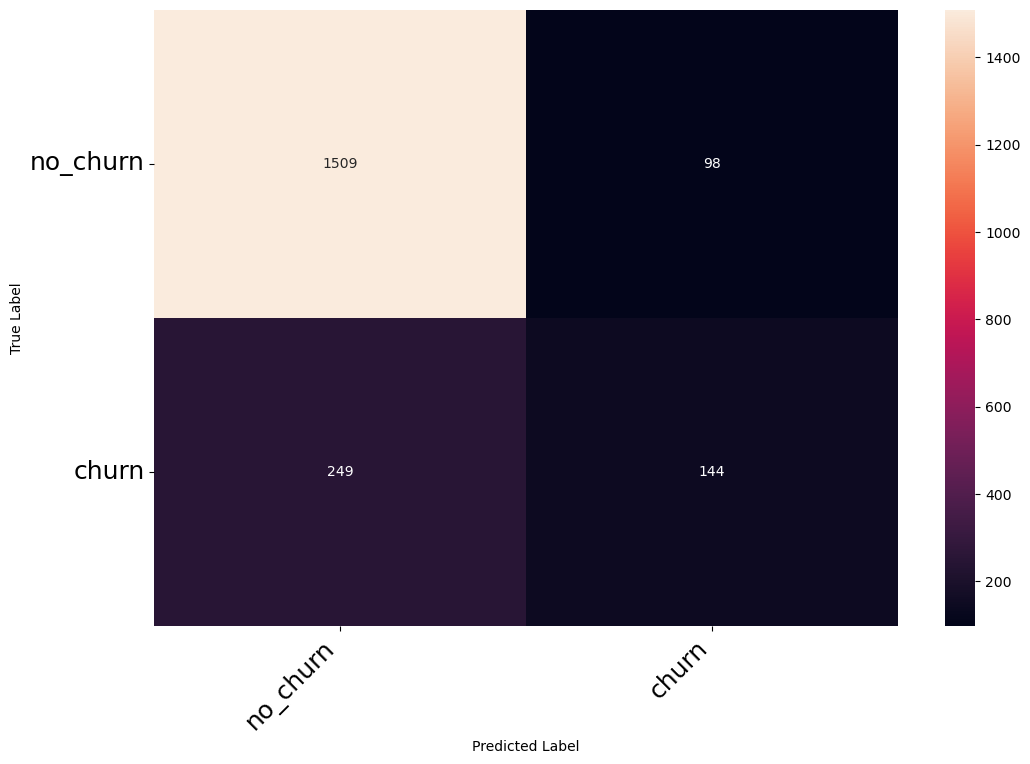

In [61]:
print_confusion_matrix(confusion_matrix(y_test,knn.predict(X_test_transformed)),['no_churn','churn'])
plt.show()  #churn etmeyen müşterilerdeki başarı iyi ancak churn tahmin etme başarısı oldukça düşük.

In [70]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(X_train_transformed, y_train)

In [71]:
Counter(y_resampled)

Counter({0: 6356, 1: 6356})

In [130]:
svc_ros = SVC().fit(X_resampled, y_resampled)

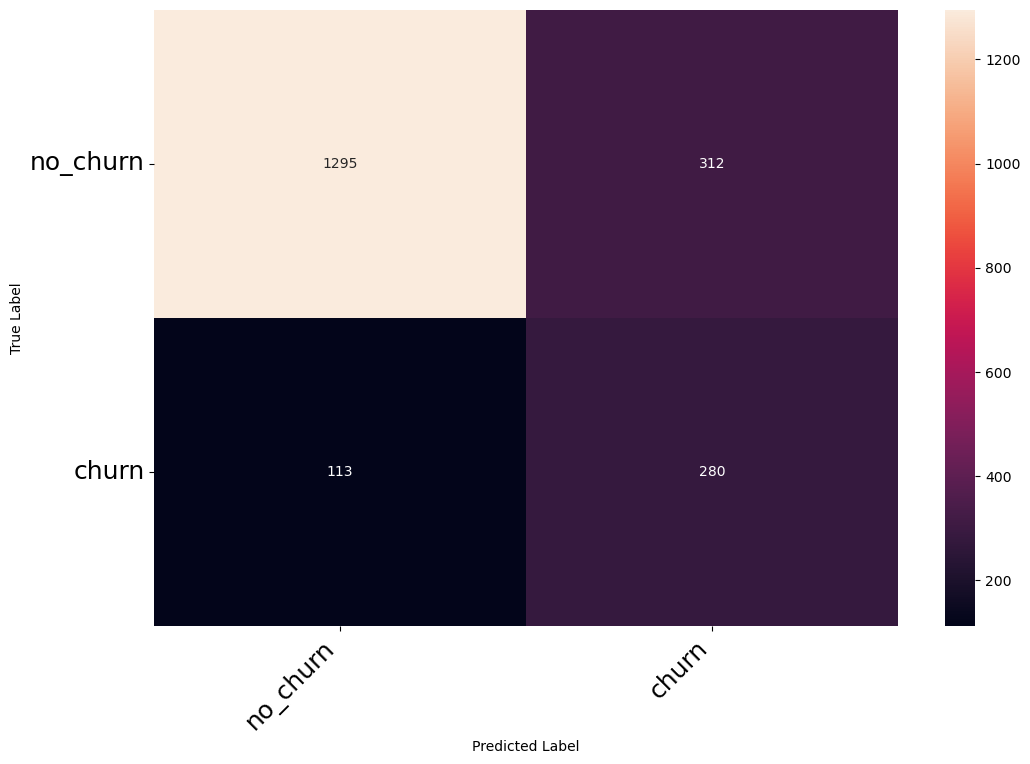

In [75]:
print_confusion_matrix(confusion_matrix(y_test, svc_ros.predict(X_test_transformed)), ['no_churn', 'churn'])
plt.show()

#140 adet churn yakalayabiliyoruz ancak no_churn başarımız azaldı.
#diğer sampling yöntemlerini deneyelim.


In [76]:
evaluate_model(svc_ros, X_test_transformed, y_test, pred_label=0)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 0,0.788,0.806,0.92,0.859,0.759


In [131]:
evaluate_model(svc_ros, X_test_transformed, y_test, pred_label=1) #churn için skorlarımız hala düşük.

,Accuracy,Recall,Precision,F1 Score,AUC Score
SVC() Class 1,0.788,0.712,0.473,0.569,0.759


In [78]:
#ADASYN deneyelim.
from imblearn.over_sampling import ADASYN
X_adasyn, y_adasyn = ADASYN().fit_resample(X_train_transformed, y_train)

In [79]:
Counter(y_adasyn)

Counter({0: 6356, 1: 6467})

In [80]:
svc_adasyn = SVC().fit(X_adasyn, y_adasyn)

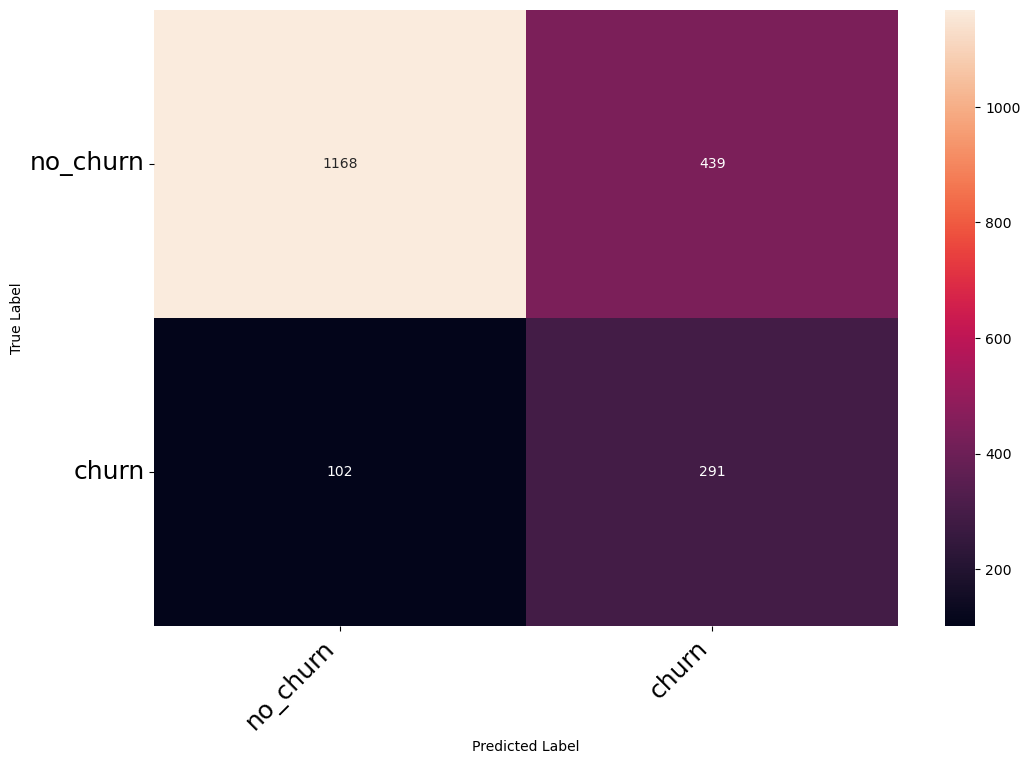

In [81]:
print_confusion_matrix(confusion_matrix(y_test, svc_adasyn.predict(X_test_transformed)), ['no_churn', 'churn'])
plt.show()

In [83]:
evaluate_model(svc_adasyn, X_test_transformed, y_test, pred_label=0)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 0,0.73,0.727,0.92,0.812,0.734


In [84]:
evaluate_model(svc_adasyn, X_test_transformed, y_test, pred_label=1)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 1,0.73,0.74,0.399,0.518,0.734


In [87]:
#adasyn yöntemi ile xgboost modelini deneyelim.  #seçim modelimmiz bu olacak gibi.
xgb_adasyn = XGBClassifier().fit(X_adasyn, y_adasyn)

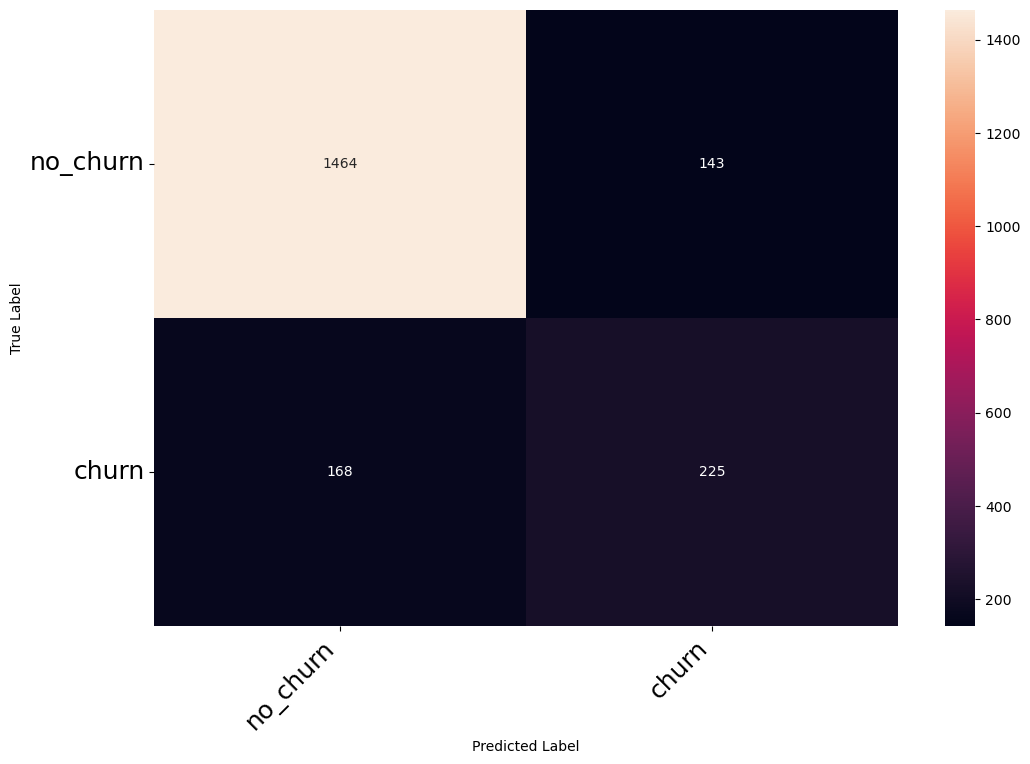

In [88]:
print_confusion_matrix(confusion_matrix(y_test, xgb_adasyn.predict(X_test_transformed)), ['no_churn', 'churn'])
plt.show()

In [89]:
evaluate_model(xgb_adasyn, X_test_transformed, y_test, pred_label=0)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 0,0.844,0.911,0.897,0.904,0.742


In [90]:
evaluate_model(xgb_adasyn, X_test_transformed, y_test, pred_label=1)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 1,0.844,0.573,0.611,0.591,0.742


In [92]:
#adasyn ile logreg   #denedik ama başarısız.

logreg_adasyn = LogisticRegression().fit(X_adasyn, y_adasyn)

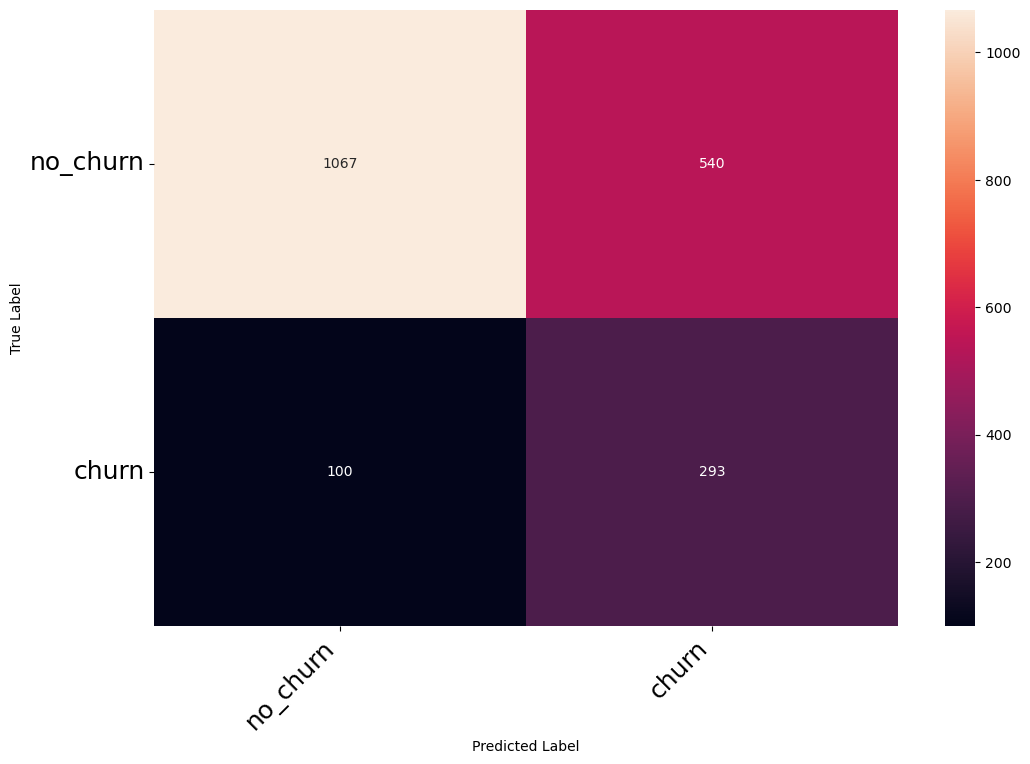

In [93]:
print_confusion_matrix(confusion_matrix(y_test, logreg_adasyn.predict(X_test_transformed)), ['no_churn', 'churn'])
plt.show()

In [94]:
#adasyn ile decision tree
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [95]:
dt_model_adasyn = DecisionTreeClassifier()
dt_model_adasyn.fit(X_adasyn, y_adasyn)

DecisionTreeClassifier()

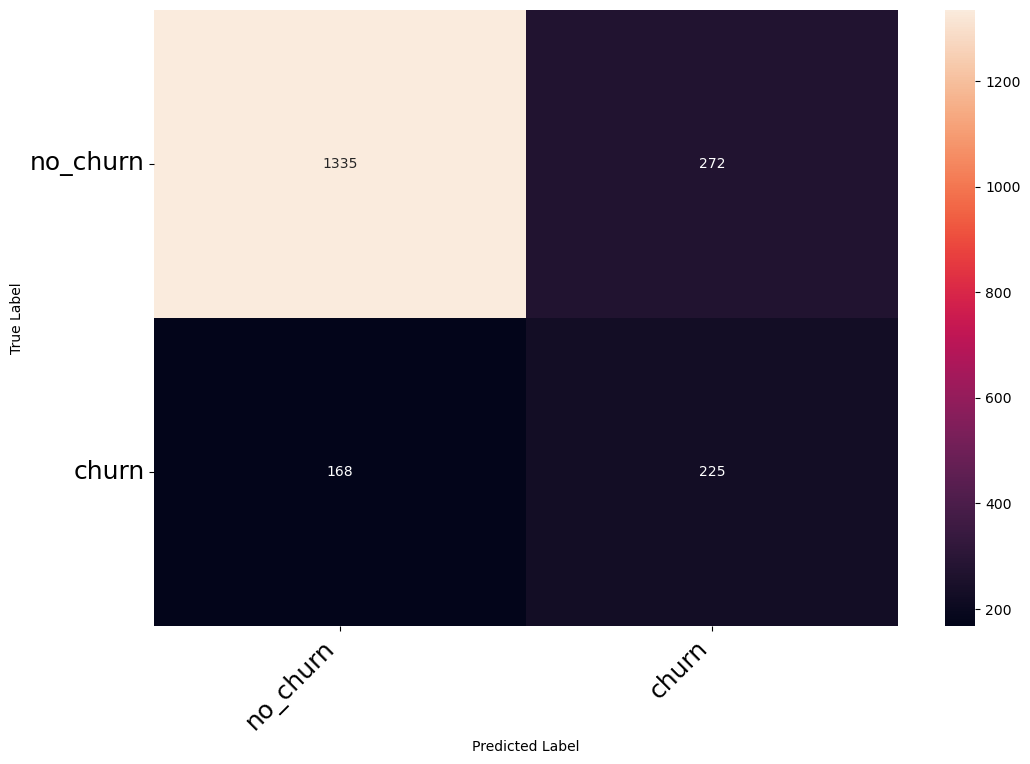

In [96]:
print_confusion_matrix(confusion_matrix(y_test, dt_model_adasyn.predict(X_test_transformed)), ['no_churn', 'churn'])
plt.show()

In [98]:
#adasyn ile random forest #bu mdel de fena değil gibi ancak xgboost halen daha başarılı gibi.
from sklearn.ensemble import RandomForestClassifier
rf_model_adasyn = RandomForestClassifier()
rf_model_adasyn.fit(X_adasyn, y_adasyn)

RandomForestClassifier()

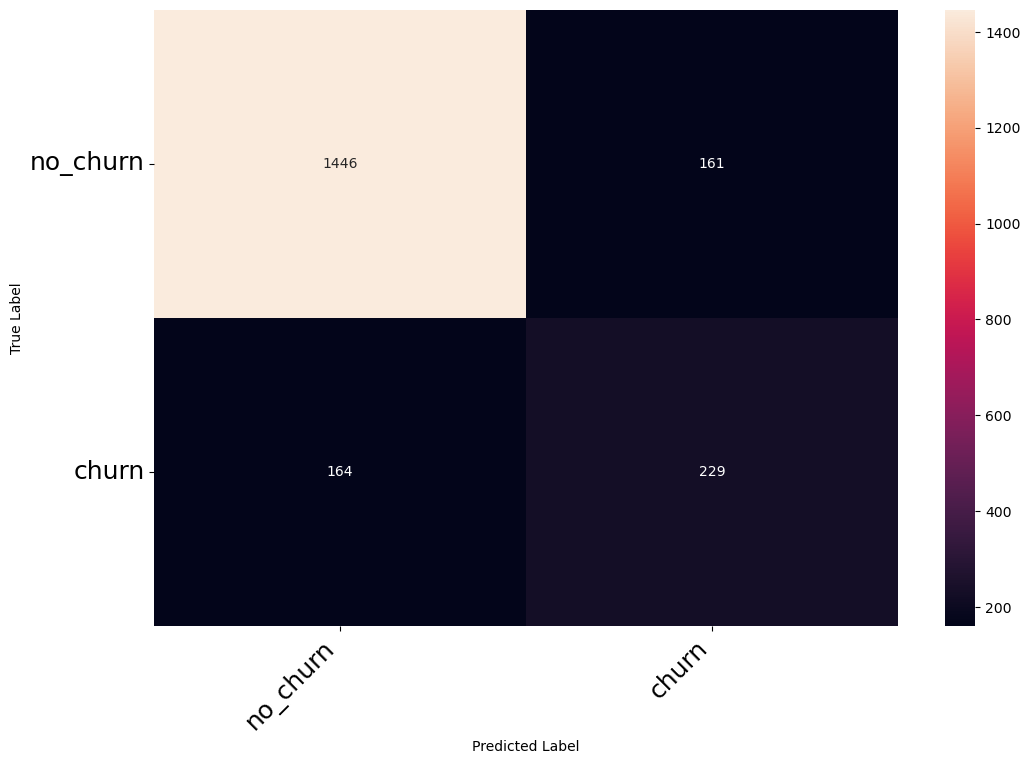

In [99]:
print_confusion_matrix(confusion_matrix(y_test, rf_model_adasyn.predict(X_test_transformed)), ['no_churn', 'churn'])
plt.show()

In [134]:
def evaluate_model_2(model, X, y, pred_label=1):

    """
    This function evaluates your model and interprets the classification metrics results in a DataFrame format.
    
    Input
    ---------
    model: Classification Model
    X: Features
    y: Label
    pred_label: Which label will be used for interprets the results
        
    Output
    -------
    metric_df: Result DataFrame
    """
    
    y_pred = model.predict(X)

    accuracy = round(accuracy_score(y, y_pred), 3)
    recall = round(recall_score(y, y_pred, pos_label = pred_label), 3)
    precision = round(precision_score(y, y_pred, pos_label = pred_label), 3)
    f1 = round(f1_score(y, y_pred, pos_label = pred_label), 3)
    auc_score = round(roc_auc_score(y, y_pred), 3)

    metric_df = pd.DataFrame([accuracy, recall, precision, f1, auc_score]).T
    metric_df.index = [str(model)]
    metric_df.columns = ["Accuracy", "Recall", "Precision", "F1 Score", "AUC Score"]

    print(metric_df)

In [135]:
#denediğimiz tüm modellerde churn başarısı için skor tablosu oluşturmak
model_list =[knn,svc_ros, svc_adasyn, xgb_adasyn, logreg_adasyn, dt_model_adasyn,rf_model_adasyn]
for model in model_list:
    evaluate_model_2(model, X_test_transformed, y_test)

                        Accuracy  Recall  Precision  F1 Score  AUC Score
KNeighborsClassifier()     0.826   0.366      0.595     0.454      0.653
       Accuracy  Recall  Precision  F1 Score  AUC Score
SVC()     0.788   0.712      0.473     0.569      0.759
       Accuracy  Recall  Precision  F1 Score  AUC Score
SVC()      0.73    0.74      0.399     0.518      0.734
                                                    Accuracy  Recall  \
XGBClassifier(base_score=None, booster=None, ca...     0.844   0.573   

                                                    Precision  F1 Score  \
XGBClassifier(base_score=None, booster=None, ca...      0.611     0.591   

                                                    AUC Score  
XGBClassifier(base_score=None, booster=None, ca...      0.742  
                      Accuracy  Recall  Precision  F1 Score  AUC Score
LogisticRegression()      0.68   0.746      0.352     0.478      0.705
                          Accuracy  Recall  Precision  F1 Score 